In [1]:

import sys

sys.path.append('../../')

import torch

from torchvision.utils import make_grid
from diffusers.models.autoencoders.autoencoder_kl import AutoencoderKL
from diffusers.models.unets.unet_2d import UNet2DModel
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# Point these to your paths
UNET_CHECKPOINT = "../../color_diffusion_checkpoints/v1/unet_epoch_8.pt"  # for example

# 1) Load the Stable Diffusion VAE (same one you used during training)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.eval().to(DEVICE)
for p in vae.parameters():
    p.requires_grad_(False)

# 2) Create a UNet2DModel with the same config you trained
unet = UNet2DModel(
    sample_size=64,
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(320, 640, 640, 1280),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

# 3) Load the trained weights
unet.load_state_dict(torch.load(UNET_CHECKPOINT, map_location="cpu"))
unet.to(DEVICE)
unet.eval()

# 4) Create the scheduler (same one used during training)
scheduler = DDPMScheduler(num_train_timesteps=1000)

# 5) Sampling loop
def sample_images(num_samples=4, num_inference_steps=50):
    unet.eval()
    with torch.no_grad():
        # Start from pure noise in VAE latent space
        latents = torch.randn((num_samples, 4, 64, 64), device=DEVICE)
        scheduler.set_timesteps(num_inference_steps)

        for t in scheduler.timesteps:
            model_out = unet(latents, t).sample
            latents = scheduler.step(model_out, t, latents).prev_sample

        # Decode the latents
        # (0.18215 = "scaling factor" from Stable Diffusion VAE)
        images = vae.decode(latents / 0.18215).sample

    # Convert [-1,1] range to [0,1] for visualization
    images = (images * 0.5 + 0.5).clamp(0, 1)
    return images

/Users/lapuerta/miniconda3/envs/cell-diffusion-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


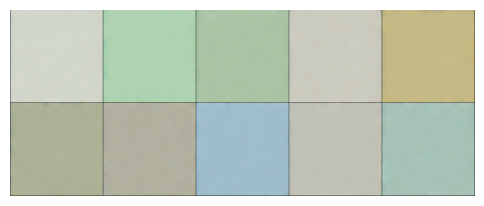

In [2]:
# 6) Generate and visualize
images = sample_images(num_samples=10, num_inference_steps=10)
grid = make_grid(images, nrow=5)  # shape is (3, H, W)

# Convert the grid tensor to a PIL image
grid_pil = to_pil_image(grid)

# Show it in the notebook
plt.figure(figsize=(6, 6))
plt.imshow(grid_pil)
plt.axis("off")
plt.show()

In [3]:
import torch.nn.functional as F

def identity_test(unet, vae, scheduler, real_image, device):
    """
    Checks if the model can 'reconstruct' latents at t=0,
    i.e., it should predict zero noise if there's no added noise.
    """
    unet.eval()
    real_image = real_image.to(device)

    with torch.no_grad():
        latents = vae.encode(real_image).latent_dist.sample()
        latents = latents * 0.18215  # scaling factor for SD VAE

        # t=0 → no noise added
        t = torch.tensor([0] * latents.shape[0], device=device).long()
        noisy_latents = latents  # unchanged

        predicted_noise = unet(noisy_latents, t).sample
        true_noise = torch.zeros_like(latents)
        mse = F.mse_loss(predicted_noise, true_noise).item()

    unet.train()
    return mse

In [4]:
import torchvision.transforms as transforms
from PIL import Image

test_image_paths = [
    "../../datasets/colors/black/black3.png",
    "../../datasets/colors/blue/blue3.png",
    "../../datasets/colors/green/green3.jpg",
    "../../datasets/colors/red/red3.jpg",
    "../../datasets/colors/yellow/yellow3.jpg",
]



for test_image_path in test_image_paths:
    test_img = Image.open(test_image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

    test_img_tensor = transform(test_img).unsqueeze(0)  # shape [1, 3, 256, 256]
    mse = identity_test(unet, vae, scheduler, test_img_tensor, DEVICE)
    print(f"Identity function MSE (t=0): {mse:.6f}")

Identity function MSE (t=0): 0.095256
Identity function MSE (t=0): 0.022450
Identity function MSE (t=0): 0.046071
Identity function MSE (t=0): 0.272961
Identity function MSE (t=0): 0.144364
